# Hospital Readmissions Data Analysis and Recommendations for Reduction

### Background
In October 2012, the US government's Center for Medicare and Medicaid Services (CMS) began reducing Medicare payments for Inpatient Prospective Payment System hospitals with excess readmissions. Excess readmissions are measured by a ratio, by dividing a hospital’s number of “predicted” 30-day readmissions for heart attack, heart failure, and pneumonia by the number that would be “expected,” based on an average hospital with similar patients. A ratio greater than 1 indicates excess readmissions.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bokeh.plotting as bkp
from scipy import stats
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings

In [2]:
# read in readmissions data provided
hospital_read_df = pd.read_csv('data/cms_hospital_readmissions.csv')

In [3]:
#Data info
hospital_read_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 12 columns):
Hospital Name                 16860 non-null object
Provider Number               16860 non-null int64
State                         16860 non-null object
Measure Name                  16860 non-null object
Number of Discharges          16860 non-null object
Footnote                      3129 non-null float64
Excess Readmission Ratio      13731 non-null float64
Predicted Readmission Rate    13731 non-null float64
Expected Readmission Rate     13731 non-null float64
Number of Readmissions        11497 non-null float64
Start Date                    16860 non-null object
End Date                      16860 non-null object
dtypes: float64(5), int64(1), object(6)
memory usage: 1.5+ MB


In [4]:
hospital_read_df.head(3)

,Hospital Name,Provider Number,State,Measure Name,Number of Discharges,Footnote,Excess Readmission Ratio,Predicted Readmission Rate,Expected Readmission Rate,Number of Readmissions,Start Date,End Date
0,FROEDTERT MEMORIAL LUTHERAN HOSPITAL,520177,WI,READM-30-HIP-KNEE-HRRP,242,NaN,1.9095,10.8,5.6,38.0,07/01/2010,06/30/2013
1,PROVIDENCE HOSPITAL,90006,DC,READM-30-HIP-KNEE-HRRP,247,NaN,1.7521,9.2,5.3,33.0,07/01/2010,06/30/2013
2,BEAUFORT COUNTY MEMORIAL HOSPITAL,420067,SC,READM-30-HIP-KNEE-HRRP,586,NaN,1.5836,7.6,4.8,53.0,07/01/2010,06/30/2013


****
## Preliminary Analysis

In [5]:
# deal with missing and inconvenient portions of data 
clean_hospital_read_df = hospital_read_df[hospital_read_df['Number of Discharges'] != 'Not Available']
clean_hospital_read_df.loc[:, 'Number of Discharges'] = clean_hospital_read_df['Number of Discharges'].astype(int)
clean_hospital_read_df = clean_hospital_read_df.sort_values('Number of Discharges')
warnings.filterwarnings('ignore')

C:\Users\AlanPC\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


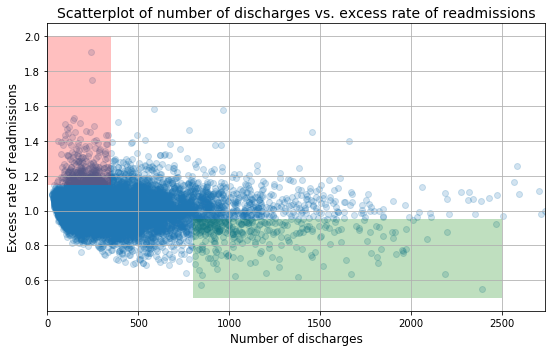

In [6]:
# generate a scatterplot for number of discharges vs. excess rate of readmissions
# lists work better with matplotlib scatterplot function
x = [a for a in clean_hospital_read_df['Number of Discharges'][81:-3]]
y = list(clean_hospital_read_df['Excess Readmission Ratio'][81:-3])

fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(x, y,alpha=0.2)

ax.fill_between([0,350], 1.15, 2, facecolor='red', alpha = .25, interpolate=True)
ax.fill_between([800,2500], .5, .95, facecolor='green', alpha = .25, interpolate=True)

ax.set_xlim([0, max(x)])
ax.set_xlabel('Number of discharges', fontsize=12)
ax.set_ylabel('Excess rate of readmissions', fontsize=12)
ax.set_title('Scatterplot of number of discharges vs. excess rate of readmissions', fontsize=14)

ax.grid(True)
fig.tight_layout()

Although it seems that rate of readmissions is trending down with increasing number of discharges we cannot be certain unless we do some statisical tests.

****
#### We will do some hypothesis testing.

Null Hypothesis: The Excess Readmission Ratio are the same across hospitals, regardless of the size
Alternative Hypothesis: There are differences in the Excess Readmission Ratio among the hospitals

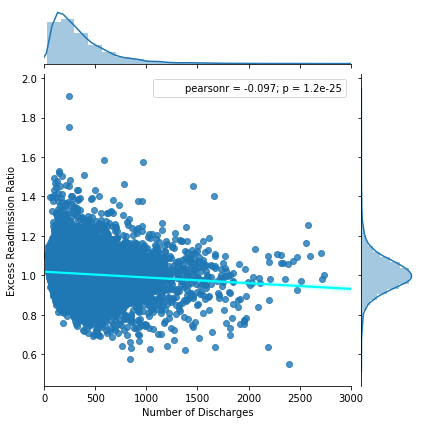

In [7]:
_ = sns.jointplot(x="Number of Discharges", y="Excess Readmission Ratio", 
            data=clean_hospital_read_df, kind='reg', xlim=(0,3000),
            joint_kws={'line_kws':{'color':'cyan'}}) 

From the graph above we can see that there is a pearsonr coefficient of -0.097 and a p value of 1.2e-25, which means there is a significant difference between the number of discharges and excess readmission ratio.

+ In hospitals/facilities with number of discharges < 100, mean excess readmission rate is 1.023 and 63% have excess readmission rate greater than 1 
+ In hospitals/facilities with number of discharges > 1000, mean excess readmission rate is 0.978 and 44% have excess readmission rate greater than 1 

In [12]:
#Create dataframe for 'large', 'medium', and 'small' hospitals
#I seperated them into 0-100, 101-999, 1000+ 
small_hosp = clean_hospital_read_df[(clean_hospital_read_df['Number of Discharges'] <= 100)]
#Clean out the nulls
small_hosp = small_hosp[small_hosp["Excess Readmission Ratio"].notnull()]
large_hosp = clean_hospital_read_df[clean_hospital_read_df['Number of Discharges'] >= 1000]
med_hosp = clean_hospital_read_df[(clean_hospital_read_df['Number of Discharges'] < 1000) 
                                  & (clean_hospital_read_df['Number of Discharges'] > 100)]

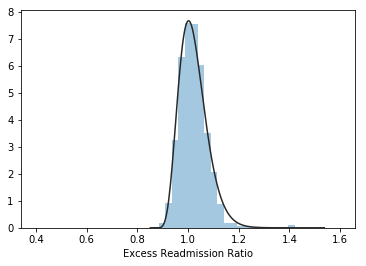

In [13]:
sns.distplot(small_hosp["Excess Readmission Ratio"], kde=False, fit=stats.gamma, hist_kws={"range": [.4,1.6]})
plt.show()

In [14]:
small_norm_test = stats.mstats.normaltest(small_hosp["Excess Readmission Ratio"])
print("Z stat is {:1.3f} and p-value is {:1.8f}".format(small_norm_test.statistic, small_norm_test.pvalue))

Z stat is 611.518 and p-value is 0.00000000


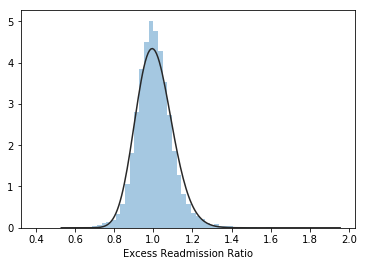

In [15]:
sns.distplot(med_hosp["Excess Readmission Ratio"], kde=False, fit=stats.gamma, hist_kws={"range": [.4,1.6]})

In [16]:
med_norm_test = stats.mstats.normaltest(med_hosp["Excess Readmission Ratio"])
print("Z stat is {:1.3f} and p-value is {:1.8f}".format(med_norm_test.statistic, med_norm_test.pvalue))

Z stat is 1403.708 and p-value is 0.00000000


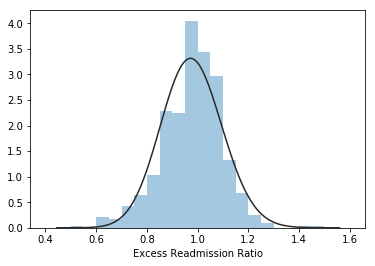

In [17]:
sns.distplot(large_hosp["Excess Readmission Ratio"], kde=False, fit=stats.gamma, hist_kws={"range": [.4,1.6]})
plt.show()

In [18]:
large_norm_test = stats.mstats.normaltest(large_hosp["Excess Readmission Ratio"])
print("Z stat is {:1.3f} and p-value is {:1.8f}".format(large_norm_test.statistic, large_norm_test.pvalue))

Z stat is 16.875 and p-value is 0.00021660


In [19]:
#Mean
print("Mean:",small_hosp["Excess Readmission Ratio"].mean())
#Excess readmission rate greater than 1
print("Excess readmission rate greater than 1", 100*len(small_hosp[small_hosp["Excess Readmission Ratio"] > 1.0])/len(small_hosp))

Mean: 1.0220883892068686
Excess readmission rate greater than 1 62.632869991823384


In [20]:
#Mean
print("Mean:",large_hosp["Excess Readmission Ratio"].mean())
#Excess readmission rate greater than 1
print("Excess readmission rate greater than 1", 100*len(large_hosp[large_hosp["Excess Readmission Ratio"] > 1.0])/len(large_hosp))

Mean: 0.9783342672413797
Excess readmission rate greater than 1 44.39655172413793


+ In hospitals/facilities with number of discharges < 100, mean excess readmission rate is 1.023 and 63% have excess readmission rate greater than 1 
+ In hospitals/facilities with number of discharges > 1000, mean excess readmission rate is 0.978 and 44% have excess readmission rate greater than 1 

It seems that larger hospitals have less of a chance for readmission, however it is still too early to conclude whether or not it is due to the size of the hospital or another variable. More testing is needed.